# Sudoku Solver (v3)

Close to final form.

Objectives:

1. Assess effectiveness and performance against different test cases
 1. Back tracking
 2. Back tracking + constraint propogation
 3. Deductive logic
 4. Solution X or Dancing Links?
3. Learn some more Pandas + Matplotlib (draw some pretty graphs)
4. ~~Assess performance against other implementations~~


## Supporting Packages

**TODO**: Brief description of [sudoku](sudoku.py) and [puzzlegrid](puzzlegrid.py) libraries.


In [1]:
import sudoku as su
import puzzlegrid as pg

**TODO**: Brief description of why we need the following

In [2]:
import copy
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import HTML, display, clear_output

%matplotlib inline
plt.rcParams["figure.figsize"] = [12, 6]
pd.set_option('precision', 3)

## Help functions

**TODO:** Print puzzles descriptions.


In [3]:
def print_puzzle(puzzle):
    display(HTML(puzzle.as_html()))

def print_2_puzzles(puz1, puz2):
    display(HTML('<table><tr><td>' + puz1.as_html() + '</td><td>' + puz2.as_html() + '</td></tr></table>'))

def update_progress(label, current, total, time_so_far, test_case):
    clear_output(wait=True)
    display(HTML(f'<progress style="width: 100%" max={total} value={current}>{current} out of {total}</progress>'))
    if test_case:
        display(HTML(f"<p>Working on {label}: <i>{test_case['label']}</i>, total time so far {time_so_far:.2f} seconds</p>"))
    else:
        display(HTML(f"<p>Completed in {time_so_far:.2f} seconds</p>"))
    return

## Example class usage

Create a puzzle in `SudokuPuzzle` then use separate class `SudokuSolver`. Separation FTW.


In [4]:
puzzle = su.SudokuPuzzle(starting_grid=su.SAMPLE_PUZZLES[0]['puzzle'])
original = copy.deepcopy(puzzle)
solver = su.SudokuSolver()
solver.solve(puzzle)
print_2_puzzles(original, puzzle)

8,9,,4,,,,5,6
1,4,,3,5,,,9,
,,,,,,8,,
9,,,,,,2,,
,8,,9,6,5,,4,
,,1,,,,,,5
,,8,,,,,,
,3,,,2,1,,7,8
4,2,,,,6,,1,3
8,9,3,4,7,2,1,5,6
1,4,6,3,5,8,7,9,2


In [5]:
print(solver.max_depth, solver.backtrack_count)

49 204


# Sudoku Solution Strategies

Running some timing tests. Using 2017 Macbook Pro (2.3 GHz Intel Core i5).

## Backtracking

**TODO:** Explanation of algorithm.

### Evaluating Backtracking

In test code below, limiting `include_levels` to `Kids`, `Easy`, and `Moderate` will complete the testing in ~1 second. On the other hand:

* `Hard` extends the running time to ~9 seconds.
* `Diabolical` takes ~5 minutes.
* `Pathalogical` takes ~36 minutes.

The time is due to the poor performance of the naive "backtracking" algorithm on some (but not all) puzzles. We're also solving each puzzle `NUM_SAMPLES` times (3 by default). We then average out the running times.



In [6]:
include_levels = ['Kids', 'Easy', 'Moderate', 'Hard'] # ['Diabolical', 'Pathalogical']
test_cases = [x for x in su.SAMPLE_PUZZLES if x['level'] in include_levels]

NUM_SAMPLES=3

Using the `PuzzleTester` class. Takes test cases and then runs Sudoku solvers against each one. The list `su.SOLVERS` contains the list of solving algorithms that the solver class supports. We'll start with `backtracking`.

In [7]:
pt = pg.PuzzleTester(puzzle_class=su.SudokuPuzzle, test_samples=NUM_SAMPLES)
pt.add_testcases(test_cases)

method = 'backtracking'
puzzle = su.SudokuPuzzle()
solver = su.SudokuSolver(method=method)
n = pt.run_tests(solver, method, callback=update_progress)

Can see some results below. Sorted by time taken (longest first). Plain backtracking is always slower, and on some puzzles it's a huge difference. 

In [8]:
df = pd.DataFrame(pt.get_test_results())
df.sort_values(by=method, ascending=False).head(n=5)

,label,level,starting_clues,backtracking
5,SMH 4,Hard,22,1.447
6,SMH 5,Hard,25,0.602
7,Greg [2017],Hard,21,0.591
1,SMH 2,Easy,24,0.201
4,SMH 3,Moderate,26,0.085


## Solving Harder Puzzles

Add more test cases from [Peter Norvig](https://norvig.com/sudoku.html).

If the test results file exists we'll use the results from earlier. Otherwise, this will re-run all the tests which took ~3.5 hours on my 2017 Macbook Pro (2.3 GHz Intel Core i5).


In [9]:
import os.path

TEST_RESULTS = "sudoku_test_results.pkl"
if os.path.isfile(TEST_RESULTS):
    df = pd.read_pickle(TEST_RESULTS)
else:
    pt.add_testcases(pg.from_file("data/hardest.txt", level="Hard"))
    pt.add_testcases(pg.from_file("data/top95.txt", level="Diabolical"))
    for m in su.SOLVERS:
        solver = su.SudokuSolver(method=m)
        pt.run_tests(solver, m, callback=update_progress)
    df = pd.DataFrame(pt.get_test_results())
    df.to_pickle(TEST_RESULTS)


In [10]:
df.describe()

,starting_clues,constraintpropogation,backtracking
count,111.000,111.000,111.000
mean,21.225,0.641,35.553
std,3.502,1.889,138.756
min,17.000,0.001,0.003
25%,17.000,0.022,0.271
50%,22.000,0.073,2.155
75%,24.000,0.227,11.847
max,31.000,12.849,1181.453


So, yeah. Backtracking alone is appalling. Look it.

* 75% of the test cases are solved in ~0.2 seconds with the constraint propogation solution, but we need ~12 seconds using backtrackng alone.
* Mean time is terrible for backtracking alone (~35 seconds). 

You can see the variability better with the following plot.

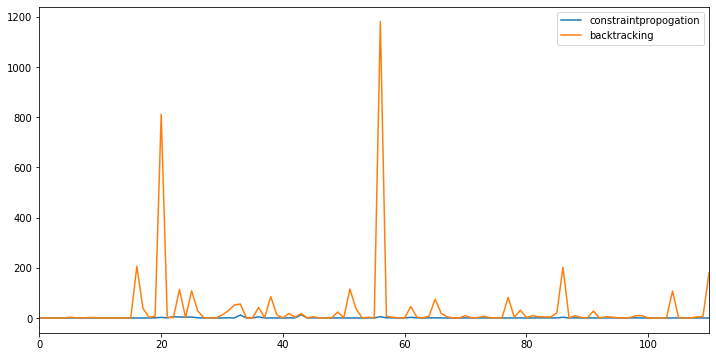

In [11]:
axs = df[su.SOLVERS].plot()

So, at this point, going to stop testing with backtracking alone. But there are a few puzzles that seem to be particularly difficult for the constraint propogation solution, so let's look at those.

## Constraint Propogation

**TODO**: Explanation of CP.

### Evaluating CP

The majority of the test puzzles are solved in < ~ 0.2 seconds, however there are some that take longer, up to a maxiumum of 12 seconds.


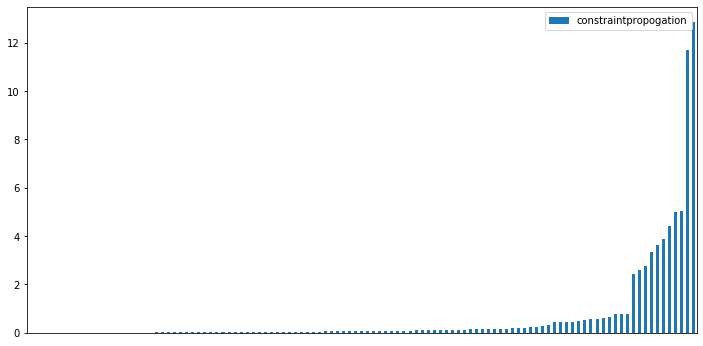

In [12]:
method = 'constraintpropogation'
axs = df.sort_values(by=method)[[method]].plot(kind='bar')
axs.xaxis.label.set_visible(False)
axs.xaxis.set_ticks([])
plt.show()

Let's take a look at those puzzles that take so much longer to solve and see if we can work out what's happening there.

In [13]:
def highlight_where_backtracking_faster(s):
    if s.constraintpropogation > s.backtracking:
        return ['background-color: yellow; color: black'] * 5
    elif s.constraintpropogation < 1.0:
        return ['background-color: lightgreen; color: black'] * 5
    else:
        return ['background-color: black; color: white'] * 5

ndf = df.sort_values(by=method, ascending=False).head(n=12)
ndf.style.apply(highlight_where_backtracking_faster, axis=1).bar(subset=[method], color='orange').format({method: "{:.3f}", 'backtracking': '{:.3f}'})


,label,level,starting_clues,constraintpropogation,backtracking
43,data/top95.txt:28,Diabolical,17,12.849,17.429
33,data/top95.txt:18,Diabolical,17,11.715,55.579
56,data/top95.txt:41,Diabolical,17,5.058,1181.453
22,data/top95.txt:7,Diabolical,17,5.017,1.683
36,data/top95.txt:21,Diabolical,17,4.417,41.908
23,data/top95.txt:8,Diabolical,17,3.899,113.350
25,data/top95.txt:10,Diabolical,17,3.640,108.091
24,data/top95.txt:9,Diabolical,17,3.336,1.705
86,data/top95.txt:71,Diabolical,17,2.773,201.816
61,data/top95.txt:46,Diabolical,17,2.618,45.625


Interesting points:

* Puzzles 7 and 9 (highlighted yellow) actually take longer to solve with the constraint propogation solution than simple backtracking
* Puzzles 21 and 46 look like good candidates for looking at closer, because the backtracking time isn't so long that we can't wait for profiler output if we want to compare profiles
* Puzzle 42 looks like a good place to start though: < ~1 second (highlighted green)

So let's look at Puzzle 42 (answer to the Ultimate Question?), using the built in Jupyet profiler tools. First though, a quick check that the total time matches up. According to original testing performance, this should take ~8 microseconds (ms).


In [14]:
puzzle42 = '......8.16..2........7.5......6...2..1....3...8.......2......7..3..8....5...4....'
puzzle.init_puzzle(puzzle42)
solver = su.SudokuSolver(method=method)
%time solver.solve(puzzle)

CPU times: user 782 ms, sys: 6.76 ms, total: 788 ms
Wall time: 826 ms


True

That looks OK. So reset the puzzle and profile below. The profiler itself adds some overhead so this takes slightly longer (~1.2 seconds).

In [15]:
puzzle.init_puzzle(puzzle42)
s = su.SudokuSolver(method=method)
%prun s.solve(puzzle)

         2059320 function calls (2030330 primitive calls) in 1.188 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   398932    0.369    0.000    0.663    0.000 sudoku.py:96(get_allowed_values)
    57980    0.251    0.000    0.848    0.000 puzzlegrid.py:256(next_best_empty_cell)
   398932    0.194    0.000    0.194    0.000 puzzlegrid.py:293(get_allowed_values)
   456848    0.114    0.000    0.114    0.000 sudoku.py:48(box_xy_to_num)
  28991/1    0.073    0.000    1.188    1.188 sudoku.py:211(solve_constraintpropogation)
    28990    0.037    0.000    0.102    0.000 puzzlegrid.py:173(set)
    28990    0.030    0.000    0.142    0.000 sudoku.py:56(set)
    28926    0.030    0.000    0.071    0.000 sudoku.py:69(clear)
    28926    0.025    0.000    0.031    0.000 puzzlegrid.py:202(clear)
   341006    0.023    0.000    0.023    0.000 {built-in method builtins.len}
    28990    0.015    0.000    0.059    0.000 puzzlegrid.py:305

Notes:

* 399K calls to `get_allowed_values`. The first entry is in [sudoku.py](sudoku.py#line_88), which gets the allowed values for the box, then calls the same method in the [parent class](puzzlegrid.py#line_321) to return the intersection of allowed cells in that row, column and box.
* Recurses into `solve_constraintpropogation` 29K times.

Compare the performance of #42 to #46. Expect #46 to take ~2.5 seconds.

In [16]:
puzzle46 = '.834.........7..5...........4.1.8..........27...3.....2.6.5....5.....8........1..'
puzzle.init_puzzle(puzzle46)
solver = su.SudokuSolver(method=method)
%time solver.solve(puzzle)

CPU times: user 257 ms, sys: 6.35 ms, total: 263 ms
Wall time: 270 ms


True

OK, this is weird. That was supposed to take ~2.5 seconds and instead finished in ~0.3 seconds. Let's run it again...and again. And this time we'll output some of the stats collected by the solver itself:

* Max Depth: The deepest stack-depth the recursion reached
* Backtracks: The number of "mistakes" made by the algorithm that resulted in it backtracking to a prior state


In [25]:
puzzle = su.SudokuPuzzle()
solver = su.SudokuSolver(method=method)
for i in range(5):
    print(f"RUN {i}")
    puzzle.init_puzzle(starting_grid=puzzle46)
    assert(not puzzle.is_solved())
    %time solver.solve(puzzle)
    print(f"Max Depth={solver.max_depth}; Backtracks={solver.backtrack_count}\n")

RUN 0
CPU times: user 2.67 s, sys: 22.1 ms, total: 2.69 s
Wall time: 2.76 s
Max Depth=63; Backtracks=105917

RUN 1
CPU times: user 2.53 s, sys: 6.37 ms, total: 2.53 s
Wall time: 2.56 s
Max Depth=63; Backtracks=105917

RUN 2
CPU times: user 219 ms, sys: 636 µs, total: 220 ms
Wall time: 220 ms
Max Depth=63; Backtracks=8766

RUN 3
CPU times: user 232 ms, sys: 836 µs, total: 232 ms
Wall time: 236 ms
Max Depth=63; Backtracks=8766

RUN 4
CPU times: user 231 ms, sys: 1.06 ms, total: 233 ms
Wall time: 235 ms
Max Depth=63; Backtracks=8766



In testing, the first two usually take ~2.5 seconds, and the last 3 take ~220 ms. Even though it's exactly the same puzzle being solved by exactly the same algorithm.

Difference is caused by the return order of the set of allowed values. Since the values are returned in a set, the order of the set members is not guaranteed to be consistent. When the order is slightly different, then the backtracking can take dramatically different search paths, with consequent impacts on run time. You can see this in the `Backtracks` reported (105K vs 88K).

In this specific case, one of the cells has allowed values (1, 9). If "1" is chosen then the solution takes 2.5 seconds to find. However if the "9" is chosen, then the search takes ~3 ms. 

If I modify the algorithm to always sort the allowed values then the performance time is always consistent. Otherwise there's a certain amount of randmomness to it.

The other change is to recreate the `puzzle` instance each time. When I do that, the performance remains consistent, because the set order remains consistent. Not sure why that is.


# Next Steps

Still to do:

* Not sure if the change in set ordering happens when running tests in `PuzzleTester` -- should check and see if that impacts results (I get an average but what's the stddev?)
* Could force the set ordering to be deterministic and test with different preferred sort orders. Expect to find the same range of performance times, even as times for individual puzzles might vary.


# Appendix

## Sources

Part of this exercise was to learn Python and Jupyter skills while also solving a problem that I found interesting. So I've largely avoided reading other people's solutions to solving Sudoku. However from time to time I've gotten stuck or just been curious about something and found the below sources useful.

* The "Top 95" and "Hardest" puzzle examples in the data directory come from [Solving Every Sudoku Puzzle (by Peter Norvig)](https://norvig.com/sudoku.html)
* [Sudoku solving algorithms](https://en.wikipedia.org/wiki/Sudoku_solving_algorithms) -- links to some sample puzzles (on Flickr of all places). Found via the [Wikipedia article on Sudoku solving algorithms](https://en.wikipedia.org/wiki/Sudoku_solving_algorithms).
* [AI Sudoku](http://www.aisudoku.com/index_en.html) -- collection of really hard puzzles.
* The [sudoku.py](sudoku.py) class has URLs to where I found some of the sample puzzles. I've attempted to use labels for them that credit the source, although it's not always clear where the original puzzle came from.
* Also used examples from [Simple sudoku solver using constraint propagation](https://gpicavet.github.io/jekyll/update/2017/12/16/sudoku-solver.html) (Grégory Picavet's Blog).


## Table formatting

Snippet below inserts some CSS to make the table look more like a Sudoku puzzle grid.


In [25]:
display(HTML('''
<style type="text/css">
.sudoku table {
    border: 3px solid red;
}

.sudoku td {
    width: 40px;
    height: 40px;
    border: 1px solid #F00;
    text-align: center;
}

.sudoku td:nth-of-type(3n) {    
    border-right: 3px solid red;
}

.sudoku tr:nth-of-type(3n) td {    
    border-bottom: 3px solid red;
}

.sudoku-solved table {
    border: 3px solid green;
}

.sudoku-solved td {
    border: 1pm solid green;
}

.sudoku-solved td:nth-of-type(3n) {    
    border-right: 3px solid green;
}

.sudoku-solved tr:nth-of-type(3n) td {    
    border-bottom: 3px solid green;
}

</style>
'''))

Scratch.txt

#10: Rico Alan Border #1
Greg: Solved in 3 ms, 59 tests, 0 backtracks
Me: Solved in 3 ms

#13: Rico Alan #3
Greg: Invalid board!
Me: Solved in 1.771 s

#11: Rico Alan #4
Greg: Solved in 30 ms, 5396 tests, 2371 backtracks
Me: Solved in 26 ms

#12: Qassim Hamza
Greg: Solved in 15 ms
Me: Solved in 59 ms

#14: World's Hardest Sudoku 2012
Greg: Solved in 21 ms
Me: Solved in 30 ms

#15: AI escargot
Greg: Solved in 1 ms, 187 tests, 12 backtracks
Me: Solved in 4 ms